In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
import pandas as pd

import keras
from keras import layers
import keras.backend
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
import keras.models
import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

Using TensorFlow backend.


1.13.1


Import data:

In [2]:
grid = 32
traindata = np.load('train_data.npz')
testdata = np.load('test_data.npz')
trainimages = traindata['circles']
testimages = testdata['circles']
trainlabels = traindata['labels']
testlabels = testdata['labels']
# toshuffletrain = np.hstack((trainimages, trainlabels))
# np.random.shuffle(toshuffletrain)
n_test = len(testlabels)
n_train = len(trainlabels)
trainimages = trainimages.reshape(n_train, grid, grid, 1)
# trainlabels = toshuffletrain[:,-1:]
# toshuffletest = np.hstack((testimages, testlabels))
testimages = testimages.reshape(n_test, grid, grid, 1)
# testlabels = toshuffletest[:,-1:]

Print a plot of data to see what it looks like!

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

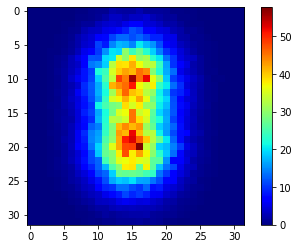

In [3]:
#plot input signal and background
sig_trainimages = np.zeros_like(trainimages[1])
bkg_trainimages = np.zeros_like(trainimages[1])
for i in range(len(trainimages)):
    if testlabels[i] == 1:
        sig_trainimages += trainimages[i]
    else:
        bkg_trainimages += trainimages[i]
#signal
display_sig = sig_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_sig, cmap = 'jet')
plt.colorbar()

Build DNN:

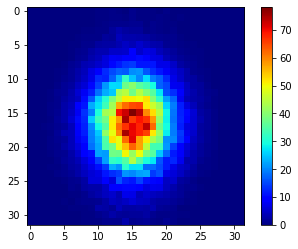

In [4]:
#background
display_bkg = bkg_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_bkg, cmap = 'jet')
plt.colorbar()

In [5]:
def build_model():
    model = keras.Sequential([
        Conv2D(32, (11, 11), activation='relu',
               input_shape=(grid, grid, 1)),
        Conv2D(32, (3, 3), activation='relu'
              ),
        MaxPool2D((2, 2)),
#         Dropout(0.2),
        Conv2D(32, (3, 3), activation='relu'
              ),
        Conv2D(32, (3, 3), activation='relu'
              ),
        MaxPool2D((2, 2)),
#         Dropout(0.2),
        Flatten(),
        Dense(64, activation=tf.nn.relu),
        Dense(64, activation=tf.nn.relu),
#         Dropout(0.2),
        Dense(1, activation=tf.nn.sigmoid)
      ])

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['mean_squared_error', 'binary_crossentropy', 'accuracy'])
    return model

Initialize model:

In [6]:
circleCNN = build_model()

Instructions for updating:
Colocations handled automatically by placer.


Test model's prediction $before$ training:

In [7]:
example_batch = trainimages[:10]
example_labels = trainlabels[:10]
example_result = circleCNN.predict(example_batch)
results = circleCNN.evaluate(example_batch, example_labels)
example_result

10/10 [==============================] - 0s 5ms/step


array([[0.49938428],
       [0.49978623],
       [0.49958116],
       [0.49880248],
       [0.49989018],
       [0.49950537],
       [0.49969527],
       [0.4997265 ],
       [0.49992836],
       [0.49988082]], dtype=float32)

Now train! (warning: if building CNN, computer tends to get loud)

In [8]:
 class PrintDot(keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs):
     if epoch % 100 == 0: 
         print('')
     print('.', end='')
    
checkpoint_path = "training/CNN_sparce_cat.h5"
if not os.path.exists("training"):
    os.mkdir("training")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)    
 EPOCHS = 1000
 early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
 history = circleCNN.fit(
   trainimages, trainlabels,
   epochs=EPOCHS, validation_split = 0.2, verbose = 0,
   callbacks=[early_stop, model_checkpoint])

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.58004, saving model to training/CNN_sparce_cat.h5

Epoch 00002: val_loss improved from 0.58004 to 0.38682, saving model to training/CNN_sparce_cat.h5

Epoch 00003: val_loss improved from 0.38682 to 0.38101, saving model to training/CNN_sparce_cat.h5

Epoch 00004: val_loss did not improve from 0.38101

Epoch 00005: val_loss did not improve from 0.38101

Epoch 00006: val_loss did not improve from 0.38101

Epoch 00007: val_loss did not improve from 0.38101

Epoch 00008: val_loss did not improve from 0.38101

Epoch 00009: val_loss improved from 0.38101 to 0.34182, saving model to training/CNN_sparce_cat.h5

Epoch 00010: val_loss did not improve from 0.34182

Epoch 00011: val_loss did not improve from 0.34182

Epoch 00012: val_loss did not improve from 0.34182

Epoch 00013: val_loss did not improve from 0.34182

Epoch 00014: val_loss did not improve from 0.34182

Epoch 00015: val_loss did not impro

Now make a plot that shows the pregression of accuracy through each training epoch.

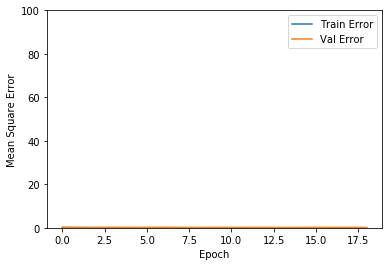

In [9]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,100])
  plt.legend()
  plt.show()

plot_history(history)

Load best weights.

In [10]:
!ls training
best_model = keras.models.load_model('training/CNN_sparce_cat.h5')
best_model.summary()
results = best_model.evaluate(testimages, testlabels)

CNN_sparce_cat.h5  CNN_sparce_cat_unshuff.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 22, 32)        3904      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (N

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

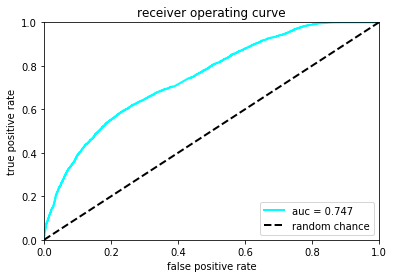

In [11]:
# Plot ROC
predict = circleCNN.predict(testimages)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels, predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

$$ \textbf{LRP} $$

In [12]:
import innvestigate
import innvestigate.utils as iutils

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


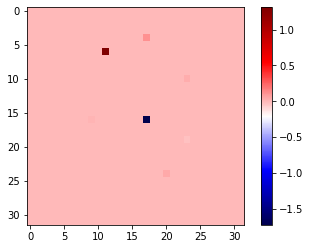

In [13]:
# Creating an analyzer
lrp_analyzer = innvestigate.create_analyzer("lrp.z", best_model)
#discoverered that innvestigate fails to run on a loaded model --> trying to find fix

# Applying the analyzer
display = trainimages[1].reshape(1,grid,grid,1) #the reshape is this way is because the input is expected to be 4 dimensions
analysis = lrp_analyzer.analyze(display)

# Displaying one result
plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.show()

In [14]:
#fix - change to predicted labels
#plot output signal and background
sig_analysis_true = np.zeros_like(analysis)
bkg_analysis_true = np.zeros_like(analysis)
sig_analysis_pred = np.zeros_like(analysis)
bkg_analysis_pred = np.zeros_like(analysis)
# sig_mask = trainlabels == 1
# bkg_mask = trainlabels == 0
# pred_sig_mask = predict >= 0.50
# pred_bkg_mask = predict < 0.50

toc = time.time()

for i in range(len(trainimages)):
    display = trainimages[i].reshape(1,grid,grid,1)
    analysis = lrp_analyzer.analyze(display)
    if trainlabels[i] == 1:
        sig_analysis_true += analysis  
    else:
        bkg_analysis_true += analysis

for i in range(len(trainimages)):
    display = trainimages[i].reshape(1,grid,grid,1)
    analysis = lrp_analyzer.analyze(display)
    if trainlabels[i] >= 0.50:
        sig_analysis_pred += analysis  
    else:
        bkg_analysis_pred += analysis

tic = time.time()

print('/n time = /n', tic-toc)


/n time = /n 65.4767804145813


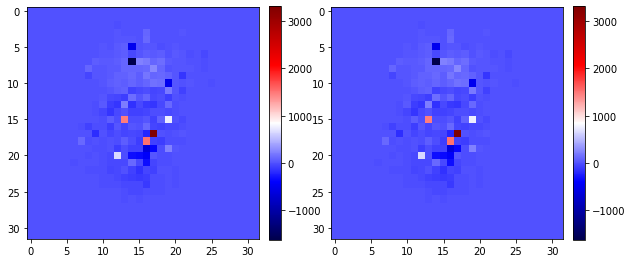

In [22]:
# Displaying the signal result
ax = plt.figure(figsize = (10,10))
ax.add_subplot(121)
im = plt.imshow(sig_analysis_true.squeeze(), cmap='seismic', interpolation='nearest')
plt.colorbar(im,fraction=0.046, pad=0.04)
ax.add_subplot(122)
im_ = plt.imshow(sig_analysis_pred.squeeze(), cmap='seismic', interpolation='nearest')
plt.colorbar(im_,fraction=0.046, pad=0.04)

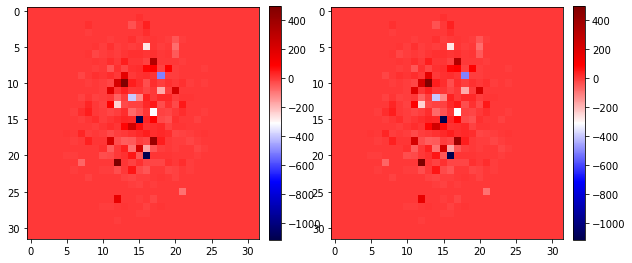

In [19]:
# Displaying the signal result
ax = plt.figure(figsize = (10,10))
plt.subplot(121)
im_ = plt.imshow(bkg_analysis_true.squeeze(), cmap='seismic', interpolation='nearest')
plt.colorbar(im_,fraction=0.046, pad=0.04)
plt.subplot(122)
im = plt.imshow(bkg_analysis_pred.squeeze(), cmap='seismic', interpolation='nearest')
plt.colorbar(im,fraction=0.046, pad=0.04)